Business Goal 3: We will identify which products are most common amongst competitors to determine where we can capitalize on market share.

Technical Proposal: For two of Glossier’s competitors, we will use NLP techniques to identify which posts and comments in the competitor subreddits contain the products identified from Glossier’s website. Similar to the business objective above, we will conduct sentiment analysis of each post to assign positive, negative, or neutral values. We will sum the number of posts and comments by product for positive posts. We will identify the top 10 products with the highest activity (positive sentiment). Similarly, we will sum the number of posts and comments by product for negative posts. We will identify the top 10 products with the highest activity (negative sentiment). We will display this information on a faceted chart to depict the worst performing products and highest performing products are of our competitors.

In [0]:
%pip install nltk

Python interpreter will be restarted.
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Python interpreter will be restarted.


In [0]:
%pip install dataframe_image

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# reading in data
competitor_comments = spark.read.parquet("dbfs:/FileStore/glossier/competitor_comments")
competitor_submissions = spark.read.parquet("dbfs:/FileStore/glossier/competitor_submissions")

In [0]:
# first let's filter out NSFW submissions
competitor_submissions = competitor_submissions.filter(competitor_submissions.over_18 == False)

# now let's filter out moderators/admins
competitor_comments = competitor_comments.filter(competitor_comments.distinguished.isNull())
competitor_submissions = competitor_submissions.filter(competitor_submissions.distinguished.isNull())

In [0]:
# keeping only necessary columns
tokeep_comments = ["author", "created_utc", "subreddit", "score", "body"]
tokeep_submissions = ["author", "created_utc", "subreddit", "score", "title", "selftext"]

competitor_comments = competitor_comments.select(*tokeep_comments)
competitor_submissions = competitor_submissions.select(*tokeep_submissions)

In [0]:
competitor_submissions.show(5)

+-------------------+-----------+---------------+-----+--------------------+--------------------+
|             author|created_utc|      subreddit|score|               title|            selftext|
+-------------------+-----------+---------------+-----+--------------------+--------------------+
|          [deleted]| 1613540105|MakeupAddiction|    1|I am EXHAUSTED wi...|           [removed]|
|         jennamycin| 1613540204|MakeupAddiction|  491|Just couldn't beh...|                    |
|       theremystics| 1613540215|MakeupAddiction|    3|Anyone have a dup...|**Link to blush c...|
|             Empra5| 1613540951|MakeupAddiction|    4|Buying foundation...|With the current ...|
|Own_Association8177| 1613541018|           Ulta|   15|   Depressed Stylist|Got demoted from ...|
+-------------------+-----------+---------------+-----+--------------------+--------------------+
only showing top 5 rows



In [0]:
competitor_comments.show(5)

+----------------+-----------+---------------+-----+--------------------+
|          author|created_utc|      subreddit|score|                body|
+----------------+-----------+---------------+-----+--------------------+
|  flowersfitness| 1650684025|        Sephora|    2|A Sephora employe...|
|joannadoesmakeup| 1650684062|MakeupAddiction|    2|This is the nices...|
|joannadoesmakeup| 1650684086|MakeupAddiction|    1|        Thank you 😊|
|    Thatsoaustin| 1650684092|        Sephora|    2|agreed! it was ve...|
|  flowersfitness| 1650684157|        Sephora|    5|Sodium chloride c...|
+----------------+-----------+---------------+-----+--------------------+
only showing top 5 rows



In [0]:
# 1031193
competitor_comments.count()

Out[6]: 1031193

In [0]:
# combining title and self text to analyze whole submission
from pyspark.sql.functions import concat_ws
competitor_submissions = competitor_submissions.select("author", "created_utc", "subreddit", "score", concat_ws(" ", \
                                                       competitor_submissions.title,competitor_submissions.selftext).alias("body"))
competitor_submissions.show(5)


+-------------------+-----------+---------------+-----+--------------------+
|             author|created_utc|      subreddit|score|                body|
+-------------------+-----------+---------------+-----+--------------------+
|          [deleted]| 1613540105|MakeupAddiction|    1|I am EXHAUSTED wi...|
|         jennamycin| 1613540204|MakeupAddiction|  491|Just couldn't beh...|
|       theremystics| 1613540215|MakeupAddiction|    3|Anyone have a dup...|
|             Empra5| 1613540951|MakeupAddiction|    4|Buying foundation...|
|Own_Association8177| 1613541018|           Ulta|   15|Depressed Stylist...|
+-------------------+-----------+---------------+-----+--------------------+
only showing top 5 rows



In [0]:
# 107510
competitor_submissions.count()

Out[8]: 107510

In [0]:
df_concat = competitor_submissions.union(competitor_comments)
df_concat.show(5)

+-------------------+-----------+---------------+-----+--------------------+
|             author|created_utc|      subreddit|score|                body|
+-------------------+-----------+---------------+-----+--------------------+
|          [deleted]| 1613540105|MakeupAddiction|    1|I am EXHAUSTED wi...|
|         jennamycin| 1613540204|MakeupAddiction|  491|Just couldn't beh...|
|       theremystics| 1613540215|MakeupAddiction|    3|Anyone have a dup...|
|             Empra5| 1613540951|MakeupAddiction|    4|Buying foundation...|
|Own_Association8177| 1613541018|           Ulta|   15|Depressed Stylist...|
+-------------------+-----------+---------------+-----+--------------------+
only showing top 5 rows



In [0]:
# 1138703
# concat was successful!
df_concat.count()

Out[10]: 1138703

Doing some data cleaning

In [0]:
# removing any null values in the body
df_concat = df_concat.filter(df_concat.body.isNotNull())
df_concat = df_concat.filter(df_concat.body != "[removed]")

In [0]:
## Data Cleaning
## resource: https://stackoverflow.com/questions/53579444/efficient-text-preprocessing-using-pyspark-clean-tokenize-stopwords-stemming

import pyspark.sql.functions as F

## removing non-alphanumeric characters and making lowercase
df_clean = df_concat.select('author', 'created_utc', 'subreddit', 'score', (F.lower(F.regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
df_clean.show(10)

+-------------------+-----------+---------------+-----+--------------------+
|             author|created_utc|      subreddit|score|                body|
+-------------------+-----------+---------------+-----+--------------------+
|          [deleted]| 1613540105|MakeupAddiction|    1|i am exhausted wi...|
|         jennamycin| 1613540204|MakeupAddiction|  491|just couldnt beha...|
|       theremystics| 1613540215|MakeupAddiction|    3|anyone have a dup...|
|             Empra5| 1613540951|MakeupAddiction|    4|buying foundation...|
|Own_Association8177| 1613541018|           Ulta|   15|depressed stylist...|
|    Snuffleupagus27| 1613541200|MakeupAddiction|    3|blush brush recom...|
|          [deleted]| 1613541640|MakeupAddiction|    1|which is a better...|
|       Salsabeans16| 1613541651|        Sephora|   61|whoa whoa is paul...|
|       Queenlytulip| 1613542015|MakeupAddiction|    3|do i need to use ...|
|          [deleted]| 1654570853|MakeupAddiction|    1|odem cosmetics pc...|

In [0]:
# resource: https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e
# resource: https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb
from sparknlp.base import DocumentAssembler

documentAssembler = DocumentAssembler() \
     .setInputCol("body") \
     .setOutputCol('document')

from sparknlp.annotator import Tokenizer

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

from sparknlp.annotator import Normalizer

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

from sparknlp.annotator import LemmatizerModel

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

from sparknlp.annotator import StopWordsCleaner
from sparknlp.base import *

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)

finisher = Finisher() \
     .setInputCols(['unigrams'])

pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                  
                 stopwords_cleaner,  
                 finisher])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
processed_review = pipeline.fit(df_clean.select("body")).transform(df_clean.select("body"))
processed_review.show(5)

+--------------------+--------------------+
|                body|   finished_unigrams|
+--------------------+--------------------+
|i am exhausted wi...|[exhaust, constan...|
|just couldnt beha...|[couldnt, behave,...|
|anyone have a dup...|[anyone, dupe, ch...|
|buying foundation...|[buy, foundation,...|
|depressed stylist...|[depressed, styli...|
+--------------------+--------------------+
only showing top 5 rows



In [0]:
# getting text distributions after cleaning

df_temp = processed_review.withColumn('text_dist', F.size('finished_unigrams'))
df_temp.describe("text_dist").show()

+-------+-----------------+
|summary|        text_dist|
+-------+-----------------+
|  count|          1116780|
|   mean|16.21481133258117|
| stddev|24.87588898162119|
|    min|                0|
|    max|             1217|
+-------+-----------------+



In [0]:
# now we must concat the clean list of words for the sparknlp model
df_clean = processed_review.withColumn("body_clean", F.concat_ws(" ", F.col("finished_unigrams"))).select('body', 'body_clean')
df_clean.show(10)

+--------------------+--------------------+
|                body|          body_clean|
+--------------------+--------------------+
|i am exhausted wi...|exhaust constant ...|
|just couldnt beha...|couldnt behave cr...|
|anyone have a dup...|anyone dupe chane...|
|buying foundation...|buy foundation on...|
|depressed stylist...|depressed stylist...|
|blush brush recom...|blush brush recom...|
|which is a better...|well foundation h...|
|whoa whoa is paul...|whoa whoa paulas ...|
|do i need to use ...|need use set powd...|
|odem cosmetics pc...|odem cosmetic pc ...|
+--------------------+--------------------+
only showing top 10 rows



In [0]:
# creating NLP pipeline
# using a twitter sentiment pipeline because Reddit and Twitter are similar as two social media platforms

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
# running the pipeline
from pyspark.sql.functions import col

empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)

data = df_clean.select(col("body_clean").alias("text"))
result = pipelineModel.transform(data)

In [0]:
result.show(5)

+--------------------+--------------------+--------------------+--------------------+
|                text|            document| sentence_embeddings|           sentiment|
+--------------------+--------------------+--------------------+--------------------+
|exhaust constant ...|[{document, 0, 16...|[{sentence_embedd...|[{category, 0, 16...|
|couldnt behave cr...|[{document, 0, 53...|[{sentence_embedd...|[{category, 0, 53...|
|anyone dupe chane...|[{document, 0, 77...|[{sentence_embedd...|[{category, 0, 77...|
|buy foundation on...|[{document, 0, 35...|[{sentence_embedd...|[{category, 0, 35...|
|depressed stylist...|[{document, 0, 12...|[{sentence_embedd...|[{category, 0, 12...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
result.select("sentiment").show(20, truncate=False)

+-----------------------------------------------------------------------------------------------------+
|sentiment                                                                                            |
+-----------------------------------------------------------------------------------------------------+
|[{category, 0, 167, negative, {sentence -> 0, positive -> 0.0, negative -> 1.0}, []}]                |
|[{category, 0, 53, positive, {sentence -> 0, positive -> 1.0, negative -> 1.3396287E-8}, []}]        |
|[{category, 0, 773, positive, {sentence -> 0, positive -> 0.8268485, negative -> 0.1731515}, []}]    |
|[{category, 0, 353, positive, {sentence -> 0, positive -> 0.9828882, negative -> 0.017111722}, []}]  |
|[{category, 0, 1227, negative, {sentence -> 0, positive -> 1.4047143E-8, negative -> 1.0}, []}]      |
|[{category, 0, 422, positive, {sentence -> 0, positive -> 0.9999026, negative -> 9.741258E-5}, []}]  |
|[{category, 0, 83, positive, {sentence -> 0, positive -> 1.0, n

In [0]:
result.select("sentiment.metadata").show(20, truncate=False)

+-------------------------------------------------------------------+
|metadata                                                           |
+-------------------------------------------------------------------+
|[{sentence -> 0, positive -> 0.0, negative -> 1.0}]                |
|[{sentence -> 0, positive -> 1.0, negative -> 1.3396287E-8}]       |
|[{sentence -> 0, positive -> 0.8268485, negative -> 0.1731515}]    |
|[{sentence -> 0, positive -> 0.9828882, negative -> 0.017111722}]  |
|[{sentence -> 0, positive -> 1.4047143E-8, negative -> 1.0}]       |
|[{sentence -> 0, positive -> 0.9999026, negative -> 9.741258E-5}]  |
|[{sentence -> 0, positive -> 1.0, negative -> 1.024573E-24}]       |
|[{sentence -> 0, positive -> 1.9203365E-22, negative -> 1.0}]      |
|[{sentence -> 0, positive -> 0.99996424, negative -> 3.5706063E-5}]|
|[{sentence -> 0, positive -> 0.8586988, negative -> 0.1413012}]    |
|[{sentence -> 0, positive -> 0.3581351, negative -> 0.6418649}]    |
|[{sentence -> 0, po

In [0]:
temp = result.select('text', F.explode('sentiment.metadata').alias("sent_score"))
temp.show()

+--------------------+--------------------+
|                text|          sent_score|
+--------------------+--------------------+
|exhaust constant ...|{sentence -> 0, p...|
|couldnt behave cr...|{sentence -> 0, p...|
|anyone dupe chane...|{sentence -> 0, p...|
|buy foundation on...|{sentence -> 0, p...|
|depressed stylist...|{sentence -> 0, p...|
|blush brush recom...|{sentence -> 0, p...|
|well foundation h...|{sentence -> 0, p...|
|whoa whoa paulas ...|{sentence -> 0, p...|
|need use set powd...|{sentence -> 0, p...|
|odem cosmetic pc ...|{sentence -> 0, p...|
|egirl makeup stil...|{sentence -> 0, p...|
|egirl makeup stil...|{sentence -> 0, p...|
|good yellow palle...|{sentence -> 0, p...|
|rakutennew signup...|{sentence -> 0, p...|
|another one old c...|{sentence -> 0, p...|
|gimme favorite li...|{sentence -> 0, p...|
|get makeup try wa...|{sentence -> 0, p...|
|mel arcane make m...|{sentence -> 0, p...|
|wet n wild discon...|{sentence -> 0, p...|
|klarna sephora cr...|{sentence 

In [0]:
# extracting score
temp = temp.select(col("text"), F.map_keys(col("sent_score")).alias("keys"), F.map_values(col("sent_score")).alias("values"))
temp = temp.select("text", temp.values[1].alias("positive_score"))
temp.show()

+--------------------+--------------+
|                text|positive_score|
+--------------------+--------------+
|exhaust constant ...|           0.0|
|couldnt behave cr...|           1.0|
|anyone dupe chane...|     0.8268485|
|buy foundation on...|     0.9828882|
|depressed stylist...|  1.4047143E-8|
|blush brush recom...|     0.9999026|
|well foundation h...|           1.0|
|whoa whoa paulas ...| 1.9203365E-22|
|need use set powd...|    0.99996424|
|odem cosmetic pc ...|     0.8586988|
|egirl makeup stil...|     0.3581351|
|egirl makeup stil...|    0.66642344|
|good yellow palle...|           1.0|
|rakutennew signup...|           1.0|
|another one old c...|     0.2800995|
|gimme favorite li...|           1.0|
|get makeup try wa...|           1.0|
|mel arcane make m...|    0.99999404|
|wet n wild discon...|    0.48622137|
|klarna sephora cr...|   0.093952276|
+--------------------+--------------+
only showing top 20 rows



In [0]:
# getting necessary columns
import pyspark.sql.functions as F

result = result.select('text', F.explode('sentiment.result').alias("sentiment"))
result.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|exhaust constant ...| negative|
|couldnt behave cr...| positive|
|anyone dupe chane...| positive|
|buy foundation on...| positive|
|depressed stylist...| negative|
+--------------------+---------+
only showing top 5 rows



In [0]:
# rejoining with the rest of the columns
df_temp = df_concat.select("author", "created_utc", "subreddit", "score")

# resource: https://stackoverflow.com/questions/63727512/unable-to-write-pyspark-dataframe-created-from-two-zipped-dataframes
# create rdds with an additional index to join
# as zipWithIndex adds the index as second column

left = result.rdd.zipWithIndex().map(lambda a: (a[1], a[0]))
right= df_temp.rdd.zipWithIndex().map(lambda a: (a[1], a[0]))

In [0]:
# resource: https://stackoverflow.com/questions/63727512/unable-to-write-pyspark-dataframe-created-from-two-zipped-dataframes
#join both rdds on index
joined = left.fullOuterJoin(right)

In [0]:
# resource: https://stackoverflow.com/questions/63727512/unable-to-write-pyspark-dataframe-created-from-two-zipped-dataframes
#restore the original columns
df_final = spark.createDataFrame(joined).select("_2._1.*", "_2._2.*")

In [0]:
df_final.show(5)

+--------------------+---------+-------------------+-----------+---------------+-----+
|                text|sentiment|             author|created_utc|      subreddit|score|
+--------------------+---------+-------------------+-----------+---------------+-----+
|exhaust constant ...| negative|          [deleted]| 1613540105|MakeupAddiction|    1|
|hey powder elf ca...| positive|     appledoughnuts| 1660532309|MakeupAddiction|    0|
|forget use discou...| negative|           sleepsyy| 1649169495|        Sephora|   46|
|prom makeup recom...| positive|RiaTheMathematician| 1619199234|         Makeup|   42|
|edgy renaissance ...| positive|          [deleted]| 1648823807|        Sephora|    1|
+--------------------+---------+-------------------+-----------+---------------+-----+
only showing top 5 rows



In [0]:
# removing any null values in the sentiment
df_final = df_final.filter(df_final.sentiment.isNotNull())


In [0]:
# performing tf idf to find important words in predicting sentiment
# resource: https://www.analyticsvidhya.com/blog/2022/09/implementing-count-vectorizer-and-tf-idf-in-nlp-using-pyspark/
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

df_tfidf = df_final.select("sentiment", "text")

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(df_tfidf)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("sentiment", "features").show(5)

+---------+--------------------+
|sentiment|            features|
+---------+--------------------+
| positive|(262144,[24016,31...|
| negative|(262144,[26144,52...|
| positive|(262144,[22346,23...|
| positive|(262144,[9492,158...|
| positive|(262144,[3834,149...|
+---------+--------------------+
only showing top 5 rows



In [0]:
for features_label in rescaledData.select("features", "sentiment").take(3):
    print(features_label)

Row(features=SparseVector(262144, {89833: 3.6073, 128247: 10.5849, 213605: 2.304, 218885: 5.0427}), sentiment='positive')
Row(features=SparseVector(262144, {30193: 9.2798, 79466: 6.3591, 81783: 2.1799, 81902: 11.9712, 93444: 6.8388, 99197: 4.309, 104220: 4.6336, 113432: 2.2843, 121517: 5.9897, 123940: 4.2139, 148921: 4.2219, 171051: 5.1586, 188835: 3.4994, 204380: 3.4932, 231008: 2.9348, 249300: 7.5541, 258728: 4.1822}), sentiment='positive')
Row(features=SparseVector(262144, {14214: 5.2136, 25328: 21.4667, 30708: 18.6208, 33808: 4.8937, 37101: 4.327, 38698: 6.0224, 51557: 6.4526, 61989: 4.4401, 66221: 12.2812, 70375: 8.3681, 81783: 2.1799, 88199: 10.2282, 94465: 5.8106, 98035: 7.5037, 116871: 8.0507, 160884: 7.3024, 208549: 9.5969, 213823: 7.6443, 216231: 7.2464, 222966: 7.3589, 239982: 4.1324, 245044: 4.0774, 254565: 11.4775, 260202: 3.8734}), sentiment='positive')


In [0]:
# getting important words using tf idf
# resource: https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document
from pyspark.sql.types import *

ndf = wordsData.select('sentiment',F.explode('words').name('expwords')).withColumn('words', F.array('expwords'))
hashudf = F.udf(lambda vector : vector.indices.tolist()[0], IntegerType())
wordtf = hashingTF.transform(ndf).withColumn('wordhash',hashudf(F.col('rawFeatures')))
wordtf.show(5)

+---------+--------+---------+--------------------+--------+
|sentiment|expwords|    words|         rawFeatures|wordhash|
+---------+--------+---------+--------------------+--------+
| positive|     tip|    [tip]|(262144,[82032],[...|   82032|
| positive| conceal|[conceal]|(262144,[257024],...|  257024|
| positive|     bad|    [bad]|(262144,[145380],...|  145380|
| positive|    dark|   [dark]|(262144,[229305],...|  229305|
| positive|  circle| [circle]|(262144,[188075],...|  188075|
+---------+--------+---------+--------------------+--------+
only showing top 5 rows



In [0]:
wordtf = wordtf.select("sentiment", "expwords", "wordhash")
wordtf.show()

+---------+----------+--------+
|sentiment|  expwords|wordhash|
+---------+----------+--------+
| negative|      face|  247394|
| negative|      burn|  240980|
| negative|     apply|  200560|
| negative|       new|   89833|
| negative|foundation|   28309|
| negative| concealer|   24837|
| negative|       try|  213605|
| negative|       new|   89833|
| negative|foundation|   28309|
| negative| concealer|   24837|
| negative|     today|   64238|
| negative|      face|  247394|
| negative|       get|  252722|
| negative|  irritate|  218939|
| negative|     start|   16004|
| negative|      burn|  240980|
| negative|      take|   55639|
| negative|      skin|   40553|
| negative|      feel|   61899|
| negative|       hot|   47197|
+---------+----------+--------+
only showing top 20 rows



In [0]:
# getting important words using tf idf
# resource: https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document
from pyspark.sql.types import MapType

udf1 = F.udf(lambda vec : dict(zip(vec.indices.tolist(),vec.values.tolist())), MapType(IntegerType(),FloatType()))
valuedf = rescaledData.select('sentiment',F.explode(udf1(F.col('features'))).name('wordhash','value'))
valuedf.show(5)

+---------+--------+---------+
|sentiment|wordhash|    value|
+---------+--------+---------+
| positive|  231746|4.7594514|
| positive|  148675| 5.009197|
| positive|  147136| 2.563387|
| positive|   32898|6.3974366|
| positive|  257024| 5.958902|
+---------+--------+---------+
only showing top 5 rows



In [0]:
# valuedf = valuedf.withColumn("wordhash",col("wordhash").cast("int")) \
#                 .withColumn("value",col("value").cast("float"))
valuedf.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- wordhash: integer (nullable = false)
 |-- value: float (nullable = true)



In [0]:
# wordtf = wordtf.withColumn("wordhash",col("wordhash").cast("int"))
wordtf.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- expwords: string (nullable = true)
 |-- wordhash: integer (nullable = true)



In [0]:
# getting top 10 words for each sentiment
# resource: https://stackoverflow.com/questions/69218494/pyspark-display-top-10-words-of-document
from pyspark.sql import Window

w = Window.partitionBy('sentiment').orderBy(F.desc('value'))
valuedf = valuedf.withColumn('rank',F.rank().over(w)).where(F.col('rank')<=10)
valuedf.show()

#valuedf.join(wordtf,['sentiment','wordhash']).groupby('sentiment').agg(F.sort_array(F.collect_set(F.struct(F.col('value'),F.col('expwords'))),asc=False).name('topn')).show(truncate=False)

+---------+--------+----------+----+
|sentiment|wordhash|     value|rank|
+---------+--------+----------+----+
| positive|  216539| 443.35663|   1|
| positive|   77212| 366.86908|   2|
| positive|   15011| 358.91846|   3|
| positive|  139226| 298.95737|   4|
| positive|  180354| 291.25555|   5|
| positive|  164174|  273.3266|   6|
| positive|  101252|  230.7333|   7|
| positive|   21045|   225.709|   8|
| positive|  198549| 210.29277|   9|
| positive|  201527|  206.2894|  10|
|  neutral|  164174| 476.56946|   1|
|  neutral|  176560| 174.21815|   2|
|  neutral|   62377| 150.94289|   3|
|  neutral|  261068|116.591354|   4|
|  neutral|  233470| 114.24752|   5|
|  neutral|   92659| 108.89369|   6|
|  neutral|  138036|  93.36764|   7|
|  neutral|  163066|   92.7559|   8|
|  neutral|  163066|   92.7559|   8|
|  neutral|  163066|   92.7559|   8|
+---------+--------+----------+----+
only showing top 20 rows



In [0]:
word_list = list(valuedf.select('wordhash').toPandas()['wordhash'])
len(word_list)

Out[38]: 30

In [0]:
df_temp = wordtf.filter(wordtf.wordhash.isin(word_list))

In [0]:
# df_temp.show()

In [0]:
# extracting brand from general makeup channels and combining with subreddit data to get big picture brand sentiment
df_final = df_final.withColumn(
            'brand',
            F.when((F.col("subreddit") == 'Sephora') | F.col("text").rlike("Sephora|sephora"), "sephora")\
            .when((F.col("subreddit") == 'Ulta') | F.col("text").rlike("Ulta|ulta"), "ulta")\
            .when((F.col("subreddit") == 'Fentybeauty') | F.col("text").rlike("Fenty|fenty"), "fenty")\
            .otherwise("general_makeup_channel"))

In [0]:
# first let's get overall sentiment by brand
from pyspark.sql.functions import desc

sentiment_by_brand = df_final.groupBy('brand', 'sentiment').count().sort(desc("brand")).toPandas()
sentiment_by_brand

,brand,sentiment,count
0,ulta,positive,77250
1,ulta,negative,19689
2,ulta,neutral,3497
3,sephora,negative,42986
4,sephora,positive,185732
5,sephora,neutral,8586
6,general_makeup_channel,positive,610925
7,general_makeup_channel,neutral,26331
8,general_makeup_channel,negative,125114
9,fenty,positive,5639


In [0]:
import pandas as pd
sentiment_by_brand = sentiment_by_brand[sentiment_by_brand["brand"] != "general_makeup_channel"]

# getting totals
sentiment_by_brand_totals = sentiment_by_brand.groupby("brand").sum("count").reset_index()

# joining
sentiment_by_brand = pd.merge(sentiment_by_brand, sentiment_by_brand_totals, how ='left', on ='brand')

sentiment_by_brand = sentiment_by_brand.rename(columns={'count_x': 'value', 'count_y': 'total_count'})

sentiment_by_brand["ratio"] = round((sentiment_by_brand["value"] / sentiment_by_brand["total_count"]), 3)

sentiment_by_brand.head()

,brand,sentiment,value,total_count,ratio
0,ulta,positive,77250,100436,0.769
1,ulta,negative,19689,100436,0.196
2,ulta,neutral,3497,100436,0.035
3,sephora,negative,42986,237304,0.181
4,sephora,positive,185732,237304,0.783


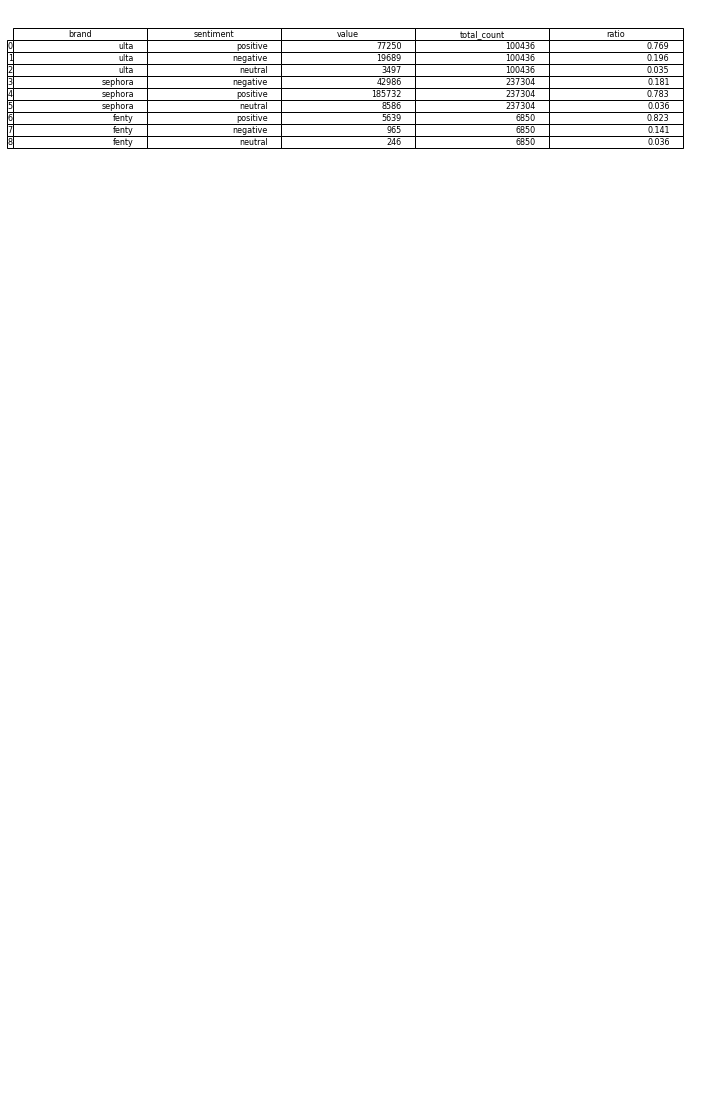

In [0]:
import matplotlib.pylab as plt
from pandas.plotting import table

plt.rcParams.update({'font.size': 30})

sentiment_by_brand.style.set_properties(**{'font-size': '20pt'})

# set fig size
fig, ax = plt.subplots(figsize=(12, 20)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
tab = table(ax, sentiment_by_brand, loc='upper right')  
# set font manually
tab.auto_set_font_size(False)
tab.set_fontsize(8) 

#plt.show()

# save the result
plt.savefig('/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/sentiment_by_brand.png')

In [0]:
## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/", "sentiment_by_brand.csv")
sentiment_by_brand.to_csv(fpath)

In [0]:
# now let's create some dummy variables based on what products the posts contain
# including general products

products = ["lipstick", "eyeshadow", "blush", "bronzer", "mascara", "foundation", "concealer", "gloss", "eyeliner", "gel", "powder", "moisturizer", "sunscreen", "shampoo", "conditioner", \
           "hairspray", "palette", "perfume", "brush", "oil", "serum", "cream", "soap", "cleanser", "makeup", "hair", "skincare", "mask", "sponge"]

In [0]:
# creating some dummy variables for analysis
df_final_dummy = df_final

for product in products:
    df_final_dummy = df_final_dummy.withColumn(product, (F.lower(df_final_dummy.text).rlike(product)))

In [0]:
df_final_dummy.show(5)

+--------------------+---------+------------+-----------+---------------+-----+--------------------+--------+---------+-----+-------+-------+----------+---------+-----+--------+-----+------+-----------+---------+-------+-----------+---------+-------+-------+-----+-----+-----+-----+-----+--------+------+-----+--------+-----+------+
|                text|sentiment|      author|created_utc|      subreddit|score|               brand|lipstick|eyeshadow|blush|bronzer|mascara|foundation|concealer|gloss|eyeliner|  gel|powder|moisturizer|sunscreen|shampoo|conditioner|hairspray|palette|perfume|brush|  oil|serum|cream| soap|cleanser|makeup| hair|skincare| mask|sponge|
+--------------------+---------+------------+-----------+---------------+-----+--------------------+--------+---------+-----+-------+-------+----------+---------+-----+--------+-----+------+-----------+---------+-------+-----------+---------+-------+-------+-----+-----+-----+-----+-----+--------+------+-----+--------+-----+------+
|

In [0]:
# 1116779
df_final_dummy.count()

Out[49]: 1106960

In [0]:
# saving intermediate dataset
# saving to a parquet
df_final_dummy.write.mode("overwrite").format('parquet').save("/FileStore/CG_intermediate_data/competitor_analysis")

In [0]:
# loading data
df_viz = spark.read.parquet("dbfs:/FileStore/CG_intermediate_data/competitor_analysis")
#df_viz.show(10)

In [0]:
from pyspark.sql.functions import desc
import pyspark.sql.functions as F

sephora = df_viz.filter(F.col("brand") == "sephora")

lipstick = sephora.groupBy("lipstick", "sentiment").count().sort(desc("count"))
lipstick = lipstick.filter(F.col("lipstick") == True)
lipstick = lipstick.select("sentiment", "count").withColumnRenamed("count","lipstick").toPandas()

eyeshadow = sephora.groupBy("eyeshadow", "sentiment").count().sort(desc("count"))
eyeshadow = eyeshadow.filter(F.col("eyeshadow") == True)
eyeshadow = eyeshadow.select("sentiment", "count").withColumnRenamed("count","eyeshadow").toPandas()

blush = sephora.groupBy("blush", "sentiment").count().sort(desc("count"))
blush = blush.filter(F.col("blush") == True)
blush = blush.select("sentiment", "count").withColumnRenamed("count","blush").toPandas()

bronzer = sephora.groupBy("bronzer", "sentiment").count().sort(desc("count"))
bronzer = bronzer.filter(F.col("bronzer") == True)
bronzer = bronzer.select("sentiment", "count").withColumnRenamed("count","bronzer").toPandas()

mascara = sephora.groupBy("mascara", "sentiment").count().sort(desc("count"))
mascara = mascara.filter(F.col("mascara") == True)
mascara = mascara.select("sentiment", "count").withColumnRenamed("count","mascara").toPandas()

foundation = sephora.groupBy("foundation", "sentiment").count().sort(desc("count"))
foundation = foundation.filter(F.col("foundation") == True)
foundation = foundation.select("sentiment", "count").withColumnRenamed("count","foundation").toPandas()

concealer = sephora.groupBy("concealer", "sentiment").count().sort(desc("count"))
concealer = concealer.filter(F.col("concealer") == True)
concealer = concealer.select("sentiment", "count").withColumnRenamed("count","concealer").toPandas()

gloss = sephora.groupBy("gloss", "sentiment").count().sort(desc("count"))
gloss = gloss.filter(F.col("gloss") == True)
gloss = gloss.select("sentiment", "count").withColumnRenamed("count","gloss").toPandas()

eyeliner = sephora.groupBy("eyeliner", "sentiment").count().sort(desc("count"))
eyeliner = eyeliner.filter(F.col("eyeliner") == True)
eyeliner = eyeliner.select("sentiment", "count").withColumnRenamed("count","eyeliner").toPandas()

gel = sephora.groupBy("gel", "sentiment").count().sort(desc("count"))
gel = gel.filter(F.col("gel") == True)
gel = gel.select("sentiment", "count").withColumnRenamed("count","gel").toPandas()

powder = sephora.groupBy("powder", "sentiment").count().sort(desc("count"))
powder = powder.filter(F.col("powder") == True)
powder = powder.select("sentiment", "count").withColumnRenamed("count","powder").toPandas()

moisturizer = sephora.groupBy("moisturizer", "sentiment").count().sort(desc("count"))
moisturizer = moisturizer.filter(F.col("moisturizer") == True)
moisturizer = moisturizer.select("sentiment", "count").withColumnRenamed("count","moisturizer").toPandas()

sunscreen = sephora.groupBy("sunscreen", "sentiment").count().sort(desc("count"))
sunscreen = sunscreen.filter(F.col("sunscreen") == True)
sunscreen = sunscreen.select("sentiment", "count").withColumnRenamed("count","sunscreen").toPandas()

shampoo = sephora.groupBy("shampoo", "sentiment").count().sort(desc("count"))
shampoo = shampoo.filter(F.col("shampoo") == True)
shampoo = shampoo.select("sentiment", "count").withColumnRenamed("count","shampoo").toPandas()

conditioner = sephora.groupBy("conditioner", "sentiment").count().sort(desc("count"))
conditioner = conditioner.filter(F.col("conditioner") == True)
conditioner = conditioner.select("sentiment", "count").withColumnRenamed("count","conditioner").toPandas()

hairspray = sephora.groupBy("hairspray", "sentiment").count().sort(desc("count"))
hairspray = hairspray.filter(F.col("hairspray") == True)
hairspray = hairspray.select("sentiment", "count").withColumnRenamed("count","hairspray").toPandas()

palette = sephora.groupBy("palette", "sentiment").count().sort(desc("count"))
palette = palette.filter(F.col("palette") == True)
palette = palette.select("sentiment", "count").withColumnRenamed("count","palette").toPandas()

perfume = sephora.groupBy("perfume", "sentiment").count().sort(desc("count"))
perfume = perfume.filter(F.col("perfume") == True)
perfume = perfume.select("sentiment", "count").withColumnRenamed("count","perfume").toPandas()

brush = sephora.groupBy("brush", "sentiment").count().sort(desc("count"))
brush = brush.filter(F.col("brush") == True)
brush = brush.select("sentiment", "count").withColumnRenamed("count","brush").toPandas()

oil = sephora.groupBy("oil", "sentiment").count().sort(desc("count"))
oil = oil.filter(F.col("oil") == True)
oil = oil.select("sentiment", "count").withColumnRenamed("count","oil").toPandas()

serum = sephora.groupBy("serum", "sentiment").count().sort(desc("count"))
serum = serum.filter(F.col("serum") == True)
serum = serum.select("sentiment", "count").withColumnRenamed("count","serum").toPandas()

cleanser = sephora.groupBy("cleanser", "sentiment").count().sort(desc("count"))
cleanser = cleanser.filter(F.col("cleanser") == True)
cleanser = cleanser.select("sentiment", "count").withColumnRenamed("count","cleanser").toPandas()

soap = sephora.groupBy("soap", "sentiment").count().sort(desc("count"))
soap = soap.filter(F.col("soap") == True)
soap = soap.select("sentiment", "count").withColumnRenamed("count","soap").toPandas()

skincare = sephora.groupBy("skincare", "sentiment").count().sort(desc("count"))
skincare = skincare.filter(F.col("skincare") == True)
skincare = skincare.select("sentiment", "count").withColumnRenamed("count","skincare").toPandas()

sponge = sephora.groupBy("sponge", "sentiment").count().sort(desc("count"))
sponge = sponge.filter(F.col("sponge") == True)
sponge = sponge.select("sentiment", "count").withColumnRenamed("count","sponge").toPandas()


In [0]:
import pandas as pd

products2 = ["lipstick", "eyeshadow", "blush", "bronzer", "mascara", "foundation", "concealer", "gloss", "eyeliner", "gel", "powder", "moisturizer", "sunscreen", "shampoo", "conditioner", \
           "hairspray", "palette", "perfume", "brush", "oil", "serum", "soap", "cleanser", "skincare", "sponge"]

sephora_viz = pd.merge(lipstick, eyeshadow, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, blush, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, bronzer, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, mascara, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, foundation, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, concealer, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, gloss, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, eyeliner, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, gel, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, powder, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, moisturizer, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, sunscreen, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, shampoo, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, conditioner, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, hairspray, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, palette, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, perfume, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, brush, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, oil, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, serum, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, soap, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, cleanser, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, skincare, how ='outer', on ='sentiment')
sephora_viz = pd.merge(sephora_viz, sponge, how ='outer', on ='sentiment')


sephora_viz = pd.melt(sephora_viz, id_vars =['sentiment'], value_vars = products2)

sephora_viz.head()

,sentiment,variable,value
0,positive,lipstick,5913
1,negative,lipstick,767
2,neutral,lipstick,204
3,positive,eyeshadow,7701
4,negative,eyeshadow,865


In [0]:
# getting totals
sephora_totals = sephora_viz.groupby("variable").sum("value").reset_index()

# joining
sephora_viz = pd.merge(sephora_viz, sephora_totals, how ='left', on ='variable')
sephora_viz = sephora_viz.rename(columns={'value_x': 'value', 'value_y': 'total_count'})

sephora_viz["ratio"] = sephora_viz["value"] / sephora_viz["total_count"]
sephora_viz.head()

,sentiment,variable,value,total_count,ratio
0,positive,lipstick,5913,6884,0.858948
1,negative,lipstick,767,6884,0.111418
2,neutral,lipstick,204,6884,0.029634
3,positive,eyeshadow,7701,8843,0.870858
4,negative,eyeshadow,865,8843,0.097817


In [0]:
## doing the same for Ulta
ulta = df_viz.filter(F.col("brand") == "ulta")

lipstick = ulta.groupBy("lipstick", "sentiment").count().sort(desc("count"))
lipstick = lipstick.filter(F.col("lipstick") == True)
lipstick = lipstick.select("sentiment", "count").withColumnRenamed("count","lipstick").toPandas()

eyeshadow = ulta.groupBy("eyeshadow", "sentiment").count().sort(desc("count"))
eyeshadow = eyeshadow.filter(F.col("eyeshadow") == True)
eyeshadow = eyeshadow.select("sentiment", "count").withColumnRenamed("count","eyeshadow").toPandas()

blush = ulta.groupBy("blush", "sentiment").count().sort(desc("count"))
blush = blush.filter(F.col("blush") == True)
blush = blush.select("sentiment", "count").withColumnRenamed("count","blush").toPandas()

bronzer = ulta.groupBy("bronzer", "sentiment").count().sort(desc("count"))
bronzer = bronzer.filter(F.col("bronzer") == True)
bronzer = bronzer.select("sentiment", "count").withColumnRenamed("count","bronzer").toPandas()

mascara = ulta.groupBy("mascara", "sentiment").count().sort(desc("count"))
mascara = mascara.filter(F.col("mascara") == True)
mascara = mascara.select("sentiment", "count").withColumnRenamed("count","mascara").toPandas()

foundation = ulta.groupBy("foundation", "sentiment").count().sort(desc("count"))
foundation = foundation.filter(F.col("foundation") == True)
foundation = foundation.select("sentiment", "count").withColumnRenamed("count","foundation").toPandas()

concealer = ulta.groupBy("concealer", "sentiment").count().sort(desc("count"))
concealer = concealer.filter(F.col("concealer") == True)
concealer = concealer.select("sentiment", "count").withColumnRenamed("count","concealer").toPandas()

gloss = ulta.groupBy("gloss", "sentiment").count().sort(desc("count"))
gloss = gloss.filter(F.col("gloss") == True)
gloss = gloss.select("sentiment", "count").withColumnRenamed("count","gloss").toPandas()

eyeliner = ulta.groupBy("eyeliner", "sentiment").count().sort(desc("count"))
eyeliner = eyeliner.filter(F.col("eyeliner") == True)
eyeliner = eyeliner.select("sentiment", "count").withColumnRenamed("count","eyeliner").toPandas()

gel = ulta.groupBy("gel", "sentiment").count().sort(desc("count"))
gel = gel.filter(F.col("gel") == True)
gel = gel.select("sentiment", "count").withColumnRenamed("count","gel").toPandas()

powder = ulta.groupBy("powder", "sentiment").count().sort(desc("count"))
powder = powder.filter(F.col("powder") == True)
powder = powder.select("sentiment", "count").withColumnRenamed("count","powder").toPandas()

moisturizer = ulta.groupBy("moisturizer", "sentiment").count().sort(desc("count"))
moisturizer = moisturizer.filter(F.col("moisturizer") == True)
moisturizer = moisturizer.select("sentiment", "count").withColumnRenamed("count","moisturizer").toPandas()

sunscreen = ulta.groupBy("sunscreen", "sentiment").count().sort(desc("count"))
sunscreen = sunscreen.filter(F.col("sunscreen") == True)
sunscreen = sunscreen.select("sentiment", "count").withColumnRenamed("count","sunscreen").toPandas()

shampoo = ulta.groupBy("shampoo", "sentiment").count().sort(desc("count"))
shampoo = shampoo.filter(F.col("shampoo") == True)
shampoo = shampoo.select("sentiment", "count").withColumnRenamed("count","shampoo").toPandas()

conditioner = ulta.groupBy("conditioner", "sentiment").count().sort(desc("count"))
conditioner = conditioner.filter(F.col("conditioner") == True)
conditioner = conditioner.select("sentiment", "count").withColumnRenamed("count","conditioner").toPandas()

hairspray = ulta.groupBy("hairspray", "sentiment").count().sort(desc("count"))
hairspray = hairspray.filter(F.col("hairspray") == True)
hairspray = hairspray.select("sentiment", "count").withColumnRenamed("count","hairspray").toPandas()

palette = ulta.groupBy("palette", "sentiment").count().sort(desc("count"))
palette = palette.filter(F.col("palette") == True)
palette = palette.select("sentiment", "count").withColumnRenamed("count","palette").toPandas()

perfume = ulta.groupBy("perfume", "sentiment").count().sort(desc("count"))
perfume = perfume.filter(F.col("perfume") == True)
perfume = perfume.select("sentiment", "count").withColumnRenamed("count","perfume").toPandas()

brush = ulta.groupBy("brush", "sentiment").count().sort(desc("count"))
brush = brush.filter(F.col("brush") == True)
brush = brush.select("sentiment", "count").withColumnRenamed("count","brush").toPandas()

oil = ulta.groupBy("oil", "sentiment").count().sort(desc("count"))
oil = oil.filter(F.col("oil") == True)
oil = oil.select("sentiment", "count").withColumnRenamed("count","oil").toPandas()

serum = ulta.groupBy("serum", "sentiment").count().sort(desc("count"))
serum = serum.filter(F.col("serum") == True)
serum = serum.select("sentiment", "count").withColumnRenamed("count","serum").toPandas()

cleanser = ulta.groupBy("cleanser", "sentiment").count().sort(desc("count"))
cleanser = cleanser.filter(F.col("cleanser") == True)
cleanser = cleanser.select("sentiment", "count").withColumnRenamed("count","cleanser").toPandas()

soap = ulta.groupBy("soap", "sentiment").count().sort(desc("count"))
soap = soap.filter(F.col("soap") == True)
soap = soap.select("sentiment", "count").withColumnRenamed("count","soap").toPandas()

skincare = ulta.groupBy("skincare", "sentiment").count().sort(desc("count"))
skincare = skincare.filter(F.col("skincare") == True)
skincare = skincare.select("sentiment", "count").withColumnRenamed("count","skincare").toPandas()

sponge = ulta.groupBy("sponge", "sentiment").count().sort(desc("count"))
sponge = sponge.filter(F.col("sponge") == True)
sponge = sponge.select("sentiment", "count").withColumnRenamed("count","sponge").toPandas()


In [0]:
ulta_viz = pd.merge(lipstick, eyeshadow, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, blush, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, bronzer, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, mascara, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, foundation, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, concealer, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, gloss, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, eyeliner, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, gel, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, powder, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, moisturizer, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, sunscreen, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, shampoo, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, conditioner, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, hairspray, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, palette, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, perfume, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, brush, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, oil, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, serum, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, soap, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, cleanser, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, skincare, how ='outer', on ='sentiment')
ulta_viz = pd.merge(ulta_viz, sponge, how ='outer', on ='sentiment')


ulta_viz = pd.melt(ulta_viz, id_vars =['sentiment'], value_vars = products2)

ulta_viz.head()

,sentiment,variable,value
0,positive,lipstick,2370
1,negative,lipstick,319
2,neutral,lipstick,74
3,positive,eyeshadow,3305
4,negative,eyeshadow,374


In [0]:
# getting totals
ulta_totals = ulta_viz.groupby("variable").sum("value").reset_index()

# joining
ulta_viz = pd.merge(ulta_viz, sephora_totals, how ='left', on ='variable')
ulta_viz = ulta_viz.rename(columns={'value_x': 'value', 'value_y': 'total_count'})

ulta_viz["ratio"] = ulta_viz["value"] / ulta_viz["total_count"]
ulta_viz.head()

,sentiment,variable,value,total_count,ratio
0,positive,lipstick,2370,6884,0.344277
1,negative,lipstick,319,6884,0.046339
2,neutral,lipstick,74,6884,0.010750
3,positive,eyeshadow,3305,8843,0.373742
4,negative,eyeshadow,374,8843,0.042293


In [0]:
## doing the same for fenty
fenty = df_viz.filter(F.col("brand") == "fenty")

lipstick = fenty.groupBy("lipstick", "sentiment").count().sort(desc("count"))
lipstick = lipstick.filter(F.col("lipstick") == True)
lipstick = lipstick.select("sentiment", "count").withColumnRenamed("count","lipstick").toPandas()

eyeshadow = fenty.groupBy("eyeshadow", "sentiment").count().sort(desc("count"))
eyeshadow = eyeshadow.filter(F.col("eyeshadow") == True)
eyeshadow = eyeshadow.select("sentiment", "count").withColumnRenamed("count","eyeshadow").toPandas()

blush = fenty.groupBy("blush", "sentiment").count().sort(desc("count"))
blush = blush.filter(F.col("blush") == True)
blush = blush.select("sentiment", "count").withColumnRenamed("count","blush").toPandas()

bronzer = fenty.groupBy("bronzer", "sentiment").count().sort(desc("count"))
bronzer = bronzer.filter(F.col("bronzer") == True)
bronzer = bronzer.select("sentiment", "count").withColumnRenamed("count","bronzer").toPandas()

mascara = fenty.groupBy("mascara", "sentiment").count().sort(desc("count"))
mascara = mascara.filter(F.col("mascara") == True)
mascara = mascara.select("sentiment", "count").withColumnRenamed("count","mascara").toPandas()

foundation = fenty.groupBy("foundation", "sentiment").count().sort(desc("count"))
foundation = foundation.filter(F.col("foundation") == True)
foundation = foundation.select("sentiment", "count").withColumnRenamed("count","foundation").toPandas()

concealer = fenty.groupBy("concealer", "sentiment").count().sort(desc("count"))
concealer = concealer.filter(F.col("concealer") == True)
concealer = concealer.select("sentiment", "count").withColumnRenamed("count","concealer").toPandas()

gloss = fenty.groupBy("gloss", "sentiment").count().sort(desc("count"))
gloss = gloss.filter(F.col("gloss") == True)
gloss = gloss.select("sentiment", "count").withColumnRenamed("count","gloss").toPandas()

eyeliner = fenty.groupBy("eyeliner", "sentiment").count().sort(desc("count"))
eyeliner = eyeliner.filter(F.col("eyeliner") == True)
eyeliner = eyeliner.select("sentiment", "count").withColumnRenamed("count","eyeliner").toPandas()

gel = fenty.groupBy("gel", "sentiment").count().sort(desc("count"))
gel = gel.filter(F.col("gel") == True)
gel = gel.select("sentiment", "count").withColumnRenamed("count","gel").toPandas()

powder = fenty.groupBy("powder", "sentiment").count().sort(desc("count"))
powder = powder.filter(F.col("powder") == True)
powder = powder.select("sentiment", "count").withColumnRenamed("count","powder").toPandas()

moisturizer = fenty.groupBy("moisturizer", "sentiment").count().sort(desc("count"))
moisturizer = moisturizer.filter(F.col("moisturizer") == True)
moisturizer = moisturizer.select("sentiment", "count").withColumnRenamed("count","moisturizer").toPandas()

sunscreen = fenty.groupBy("sunscreen", "sentiment").count().sort(desc("count"))
sunscreen = sunscreen.filter(F.col("sunscreen") == True)
sunscreen = sunscreen.select("sentiment", "count").withColumnRenamed("count","sunscreen").toPandas()

shampoo = fenty.groupBy("shampoo", "sentiment").count().sort(desc("count"))
shampoo = shampoo.filter(F.col("shampoo") == True)
shampoo = shampoo.select("sentiment", "count").withColumnRenamed("count","shampoo").toPandas()

conditioner = fenty.groupBy("conditioner", "sentiment").count().sort(desc("count"))
conditioner = conditioner.filter(F.col("conditioner") == True)
conditioner = conditioner.select("sentiment", "count").withColumnRenamed("count","conditioner").toPandas()

hairspray = fenty.groupBy("hairspray", "sentiment").count().sort(desc("count"))
hairspray = hairspray.filter(F.col("hairspray") == True)
hairspray = hairspray.select("sentiment", "count").withColumnRenamed("count","hairspray").toPandas()

palette = fenty.groupBy("palette", "sentiment").count().sort(desc("count"))
palette = palette.filter(F.col("palette") == True)
palette = palette.select("sentiment", "count").withColumnRenamed("count","palette").toPandas()

perfume = fenty.groupBy("perfume", "sentiment").count().sort(desc("count"))
perfume = perfume.filter(F.col("perfume") == True)
perfume = perfume.select("sentiment", "count").withColumnRenamed("count","perfume").toPandas()

brush = fenty.groupBy("brush", "sentiment").count().sort(desc("count"))
brush = brush.filter(F.col("brush") == True)
brush = brush.select("sentiment", "count").withColumnRenamed("count","brush").toPandas()

oil = fenty.groupBy("oil", "sentiment").count().sort(desc("count"))
oil = oil.filter(F.col("oil") == True)
oil = oil.select("sentiment", "count").withColumnRenamed("count","oil").toPandas()

serum = fenty.groupBy("serum", "sentiment").count().sort(desc("count"))
serum = serum.filter(F.col("serum") == True)
serum = serum.select("sentiment", "count").withColumnRenamed("count","serum").toPandas()

cleanser = fenty.groupBy("cleanser", "sentiment").count().sort(desc("count"))
cleanser = cleanser.filter(F.col("cleanser") == True)
cleanser = cleanser.select("sentiment", "count").withColumnRenamed("count","cleanser").toPandas()

soap = fenty.groupBy("soap", "sentiment").count().sort(desc("count"))
soap = soap.filter(F.col("soap") == True)
soap = soap.select("sentiment", "count").withColumnRenamed("count","soap").toPandas()

skincare = fenty.groupBy("skincare", "sentiment").count().sort(desc("count"))
skincare = skincare.filter(F.col("skincare") == True)
skincare = skincare.select("sentiment", "count").withColumnRenamed("count","skincare").toPandas()

sponge = fenty.groupBy("sponge", "sentiment").count().sort(desc("count"))
sponge = sponge.filter(F.col("sponge") == True)
sponge = sponge.select("sentiment", "count").withColumnRenamed("count","sponge").toPandas()


In [0]:
fenty_viz = pd.merge(lipstick, eyeshadow, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, blush, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, bronzer, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, mascara, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, foundation, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, concealer, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, gloss, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, eyeliner, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, gel, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, powder, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, moisturizer, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, sunscreen, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, shampoo, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, conditioner, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, hairspray, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, palette, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, perfume, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, brush, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, oil, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, serum, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, soap, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, cleanser, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, skincare, how ='outer', on ='sentiment')
fenty_viz = pd.merge(fenty_viz, sponge, how ='outer', on ='sentiment')


fenty_viz = pd.melt(fenty_viz, id_vars =['sentiment'], value_vars = products2)

fenty_viz.head()

,sentiment,variable,value
0,positive,lipstick,797.0
1,negative,lipstick,46.0
2,neutral,lipstick,15.0
3,positive,eyeshadow,704.0
4,negative,eyeshadow,27.0


In [0]:
# getting totals
fenty_totals = fenty_viz.groupby("variable").sum("value").reset_index()

# joining
fenty_viz = pd.merge(fenty_viz, sephora_totals, how ='left', on ='variable')
fenty_viz = fenty_viz.rename(columns={'value_x': 'value', 'value_y': 'total_count'})

fenty_viz["ratio"] = fenty_viz["value"] / fenty_viz["total_count"]
fenty_viz.head()

,sentiment,variable,value,total_count,ratio
0,positive,lipstick,797.0,6884,0.115776
1,negative,lipstick,46.0,6884,0.006682
2,neutral,lipstick,15.0,6884,0.002179
3,positive,eyeshadow,704.0,8843,0.079611
4,negative,eyeshadow,27.0,8843,0.003053


In [0]:
# joining for viz
fenty_viz["brand"] = "fenty"
ulta_viz["brand"] = "ulta"
sephora_viz["brand"] = "sephora"

final_viz = pd.concat([sephora_viz, ulta_viz, fenty_viz], axis=0)
final_viz.head()

,sentiment,variable,value,total_count,ratio,brand
0,positive,lipstick,5913.0,6884,0.858948,sephora
1,negative,lipstick,767.0,6884,0.111418,sephora
2,neutral,lipstick,204.0,6884,0.029634,sephora
3,positive,eyeshadow,7701.0,8843,0.870858,sephora
4,negative,eyeshadow,865.0,8843,0.097817,sephora


In [0]:
## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/", "competitor_sentiment_viz.csv")
final_viz.to_csv(fpath)

In [0]:
import plotly.express as px
 
fig = px.bar(final_viz[final_viz["sentiment"] == "positive"], x="variable", y="ratio", 
             color="brand", barmode = 'group',
            title = "Competitor Positive Consumer Sentiment Ratio By Product",
            color_discrete_sequence=["#9EF478", "#EDF197", "#78BCF4"])

fig.update_layout(plot_bgcolor = "white",  xaxis_title="Product", yaxis_title="% Positive Activity Of Total", title_x=0.5,
                 xaxis={'categoryorder':'total descending'})
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/", "competitor_sentiment_viz.html")
fig.write_html(fpath)
fig.show()

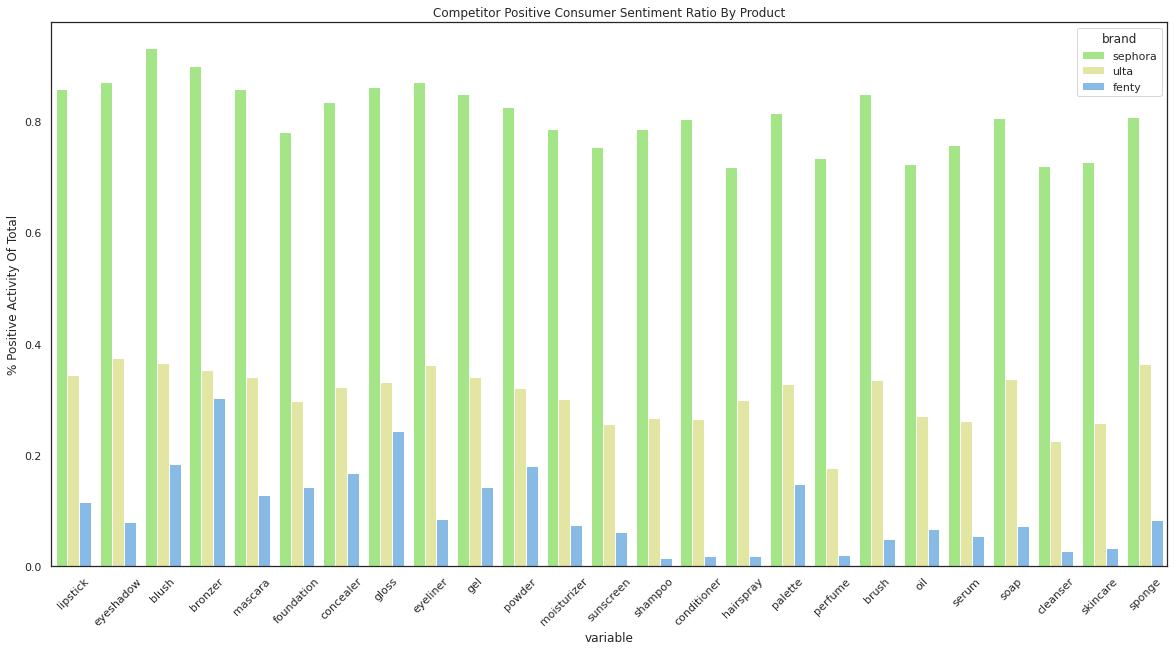

In [0]:
# adding same plot
import matplotlib.pyplot as plt
import seaborn as sns

positive_viz = final_viz[final_viz["sentiment"] == "positive"]

clrs = ["#9EF478", "#EDF197", "#78BCF4"]

# plot data in grouped manner of bar type
sns.set(font_scale=3, rc={'figure.figsize':(20,10)})
sns.set_theme(style='white')
p1 = sns.barplot(data=positive_viz, x='variable', y='ratio', hue='brand', palette=clrs)
p1.set_title('Competitor Positive Consumer Sentiment Ratio By Product')
p1.set_ylabel('% Positive Activity Of Total')
p1 = plt.xticks(rotation=45)